# Zeisel GRN Inference and Analysis (nb duplicate)

## 0. Import dependencies

In [1]:
import os
import sys
sys.path.append('../../')

from arboreto.core import *
from arboreto.utils import *

import matplotlib.pyplot as plt

## 1. Load the data (outside the scope of the arboreto API)

In [2]:
zeisel_ex_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_tf_path = '/media/tmo/data/work/datasets/TF/mm9_TFs.txt'

In [3]:
zeisel_df = pd.read_csv(zeisel_ex_path, index_col=0, sep='\t').T
zeisel_df.head()

,Tspan12,Tshz1,Fnbp1l,Adamts15,Cldn12,Rxfp1,2310042E22Rik,Sema3c,Jam2,Apbb1ip,...,Rab9,Tceanc,Msl3,Arhgap6,Mid1,Vamp7,Tmlhe,Zf12,Kdm5d,Uty
1772071015_C02,0,3,3,0,1,0,0,11,1,0,...,7,0,0,0,0,5,0,0,0,0
1772071017_G12,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1772071017_A05,0,0,6,0,1,0,2,25,1,0,...,1,0,2,0,0,3,0,0,0,7
1772071014_B06,3,2,4,0,0,0,3,1,0,0,...,3,0,1,0,0,0,0,0,0,0
1772067065_H06,0,2,1,0,0,0,0,10,0,0,...,0,0,4,0,0,3,0,0,0,0


In [4]:
zeisel_ex_matrix = zeisel_df.as_matrix().astype(np.float)
zeisel_ex_matrix

array([[ 0.,  3.,  3., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ...,  0.,  0.,  7.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.]])

In [5]:
assert(zeisel_ex_matrix.shape == (3005, 13063))

In [6]:
zeisel_gene_names = list(zeisel_df.columns)
zeisel_gene_names[:5]

['Tspan12', 'Tshz1', 'Fnbp1l', 'Adamts15', 'Cldn12']

In [7]:
zeisel_tf_names = load_tf_names(zeisel_tf_path)
zeisel_tf_names[:5]

['1700049G17Rik',
 '1700080O16Rik',
 '2210418O10Rik',
 '2310011J03Rik',
 '2310045N01Rik']

In [8]:
signal_series = zeisel_df.astype(bool).sum(axis=0)

In [44]:
nonzero_df = signal_series.to_frame('non_zero').sort_values(by='non_zero', ascending=False).reset_index()
nonzero_df.columns = ['target', 'non_zero']

nonzero_df.to_csv('zeisel_nonzero.tsv', sep='\t')
nonzero_df.head()

,target,non_zero
0,Malat1,3004
1,Calm1,2998
2,Actb,2997
3,Hsp90ab1,2993
4,Fth1,2990


In [1]:
nonzero_df.merge(meta_df, on=['target'])[['n_estimators', 'non_zero']].plot(x='non_zero', y='n_estimators', kind='scatter', figsize=(16,16))
plt.savefig('n_nonzero_vs_n_estimators.png')
plt.show()

NameError: name 'nonzero_df' is not defined

## 2. Initialize Dask client

In [10]:
from dask.distributed import Client, LocalCluster

In [11]:
client = Client(LocalCluster(memory_limit=8e9))

In [12]:
client

Client Scheduler: tcp://127.0.0.1:33187 Dashboard: http://127.0.0.1:8787,Cluster Workers: 88 Cores: 88 Memory: 704.00 GB


If you work remotely, use port forwarding to view the dashboard:

```bash
$ ssh -L 8000:localhost:8787 nostromo
```

In [95]:
client.shutdown()

## 3. Compute GRN inference graph

#### Create the dask computation graphs

In [13]:
%%time
network_graph, meta_graph = create_graph(zeisel_ex_matrix,
                                         zeisel_gene_names,
                                         zeisel_tf_names,
                                         "GBM",
                                         SGBM_KWARGS,
                                         target_genes='all',
                                         early_stop_window_length=25,
                                         include_meta=True)

CPU times: user 11.4 s, sys: 1.94 s, total: 13.3 s
Wall time: 10.7 s


#### Persist the distributed DataFrames

In [ ]:
%%time
a, b = client.persist([network_graph, meta_graph])

#### Compute results

In [24]:
%%time
network_df = a.compute(sync=True)

CPU times: user 18.2 s, sys: 2.58 s, total: 20.8 s
Wall time: 19.8 s


* CPU times: user 8min 15s, sys: 5min 41s, total: 13min 56s
* Wall time: **16min 30s**

In [25]:
%%time
meta_df = b.compute(sync=True)

CPU times: user 16.6 s, sys: 1.51 s, total: 18.2 s
Wall time: 17.3 s


## 4. Save full and top_100k networks to file

In [26]:
len(network_df)

5081193

In [27]:
len(meta_df)

13063

In [41]:
meta_df.to_csv('zeisel_meta_df.tsv', sep='\t')

In [28]:
network_df.sort_values(by='importance', ascending=0).to_csv('zeisel_sgbm_all.txt',  index=False, sep='\t')

In [29]:
top_100k = network_df.nlargest(100000, columns=['importance'])

In [30]:
top_100k.to_csv('zeisel_sgbm_100k.txt', index=False, sep='\t')

In [31]:
merged_df = top_100k.merge(meta_df, on='target')

In [32]:
merged_df.head()

,TF,target,importance,n_estimators
0,Gm14305,OTTMUSG00000016609_loc3,199.404700,739
1,Cycs,OTTMUSG00000016609_loc3,22.145701,739
2,Tpi1,OTTMUSG00000016609_loc3,16.117278,739
3,Gm14326,OTTMUSG00000016609_loc3,15.135688,739
4,Suclg1,OTTMUSG00000016609_loc3,14.291515,739


In [33]:
merged_df['imp2'] = merged_df['importance'] / merged_df['n_estimators']

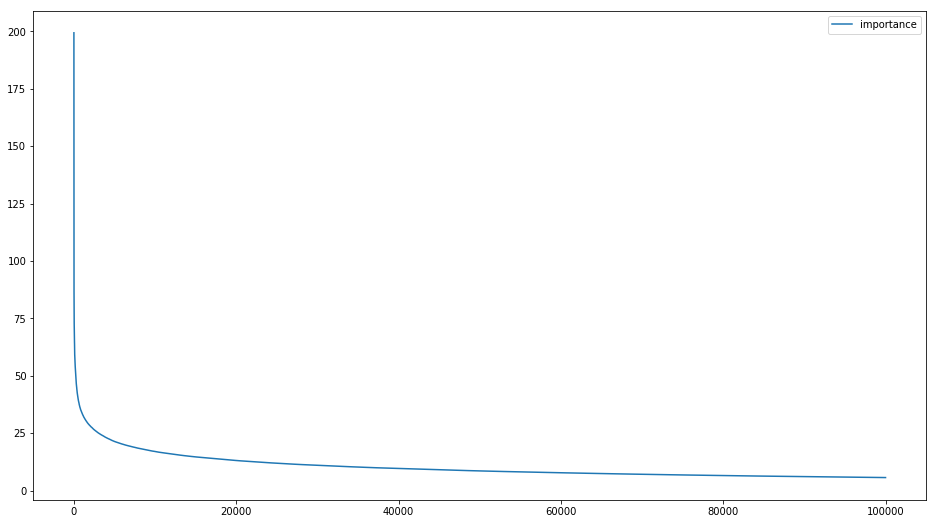

In [34]:
top_100k.plot(use_index=0, figsize=(16,9))
plt.show()

### Distribution of nr of boosting rounds per regression

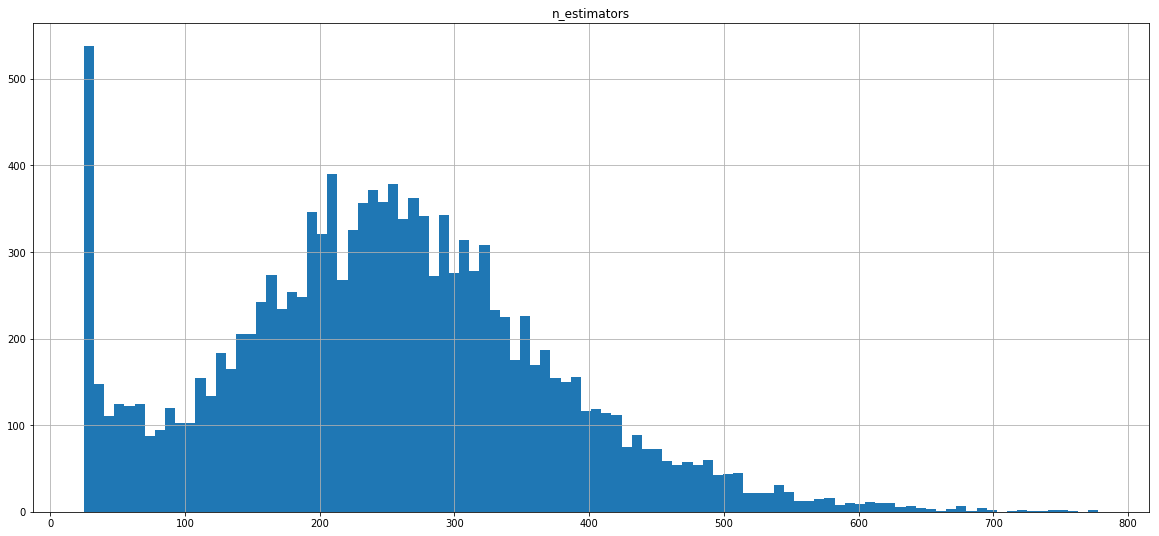

In [35]:
meta_df.hist(bins=100, figsize=(20, 9), log=0)
plt.show()

### Plot the maximum variable importance (sklearn default) vs. nr of boosting rounds

* **!= the formula in Arboreto**
* Using the sklearn default variable importances which normalizes regressions by dividing by nr of trees in the ensemble.
* Effect is that regressions with few trees also deliver high feature importances (aka network links), this is undesirable.
* In Arboreto, we omit this normalization step to make use of the nr of trees as a heuristic indicator of how much *signal* there is in a regression.

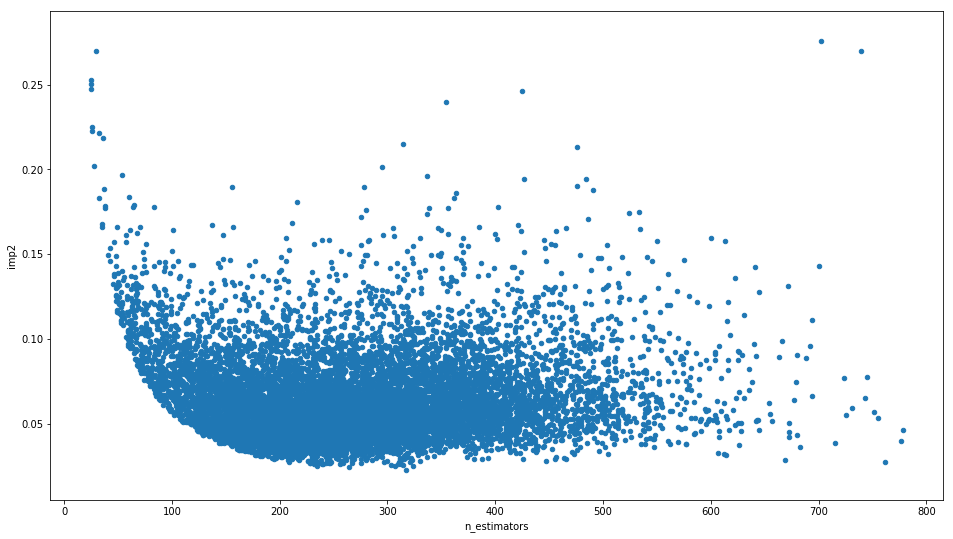

In [36]:
max_imp2_by_rounds =\
meta_df.merge(merged_df.groupby(['target'])['imp2'].nlargest(1).reset_index(), 
              how='left', 
              on=['target'])

max_imp2_by_rounds.plot.scatter(x='n_estimators', y='imp2', figsize=(16, 9))
plt.show()

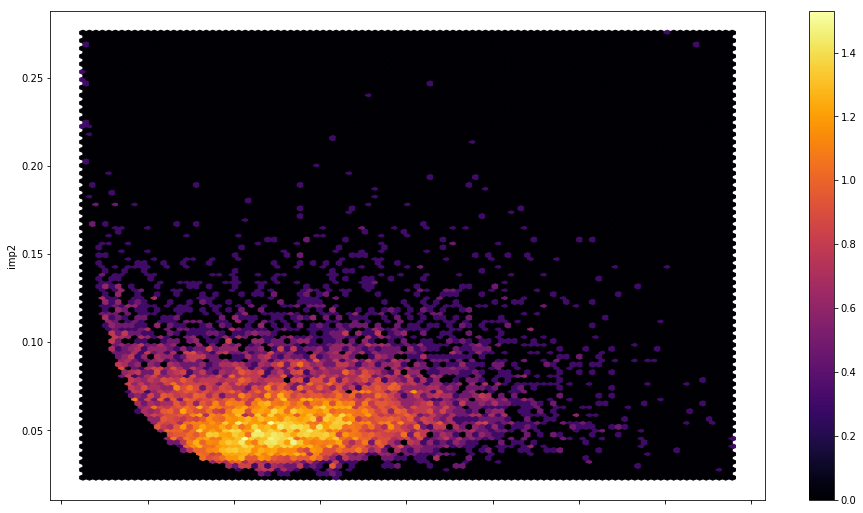

In [37]:
max_imp2_by_rounds.plot.hexbin(x='n_estimators', 
                               y='imp2', 
                               bins='log', 
                               cmap='inferno',
                               figsize=(16, 9))
plt.show()

### Plotting corrected feature importance (Arboreto SGBM default) vs. nr of boosting rounds

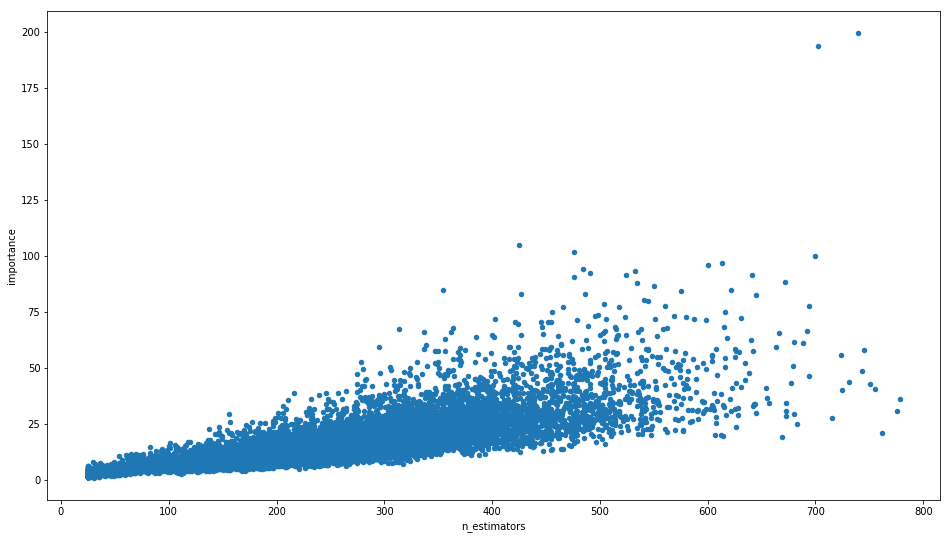

In [38]:
max_imp_by_rounds =\
meta_df.merge(network_df.groupby(['target'])['importance'].nlargest(1).reset_index(), 
              how='left', 
              on=['target'])

max_imp_by_rounds.plot.scatter(x='n_estimators', y='importance', figsize=(16, 9))
plt.show()

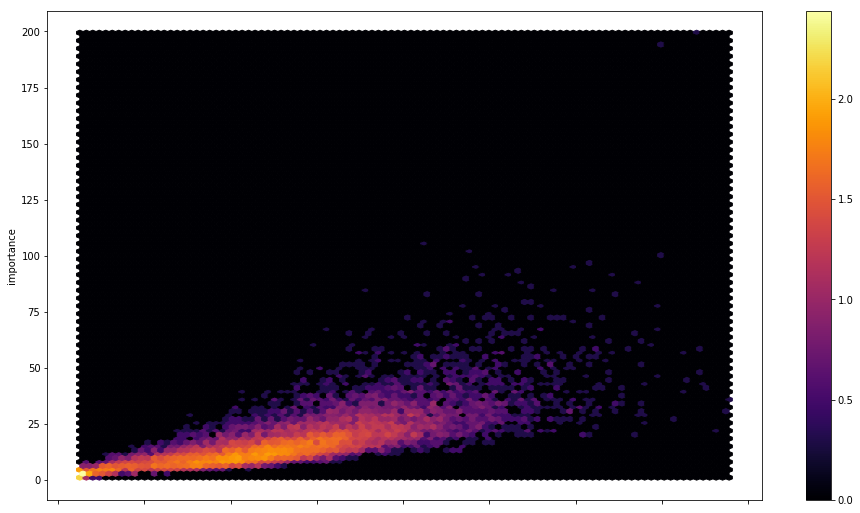

In [39]:
max_imp_by_rounds.plot.hexbin(x='n_estimators', 
                              bins='log',
                              cmap='inferno',
                              y='importance',
                              figsize=(16, 9))
plt.show()

# Links in common with GENIE3

In [77]:
z_genie3 = pd.read_csv('/media/tmo/data/work/datasets/benchmarks/genie3/zeisel/zeisel.filtered.genie3.txt', header=None, sep='\t')
z_genie3.columns=['TF', 'target', 'importance']

In [81]:
inner = z_genie3.merge(top_100k, how='inner', on=['TF', 'target'])

In [82]:
len(inner)

62301

In [83]:
inner_50k = z_genie3[:50000].merge(top_100k[:50000], how='inner', on=['TF', 'target'])

In [84]:
len(inner_50k)

30561

In [85]:
inner_25k = z_genie3[:25000].merge(top_100k[:25000], how='inner', on=['TF', 'target'])

In [87]:
len(inner_25k) / 25000

0.60272

In [91]:
inner_10k = z_genie3[:10000].merge(top_100k[:10000], how='inner', on=['TF', 'target'])

In [92]:
len(inner_10k)

5918

In [93]:
inner_5k = z_genie3[:5000].merge(top_100k[:5000], how='inner', on=['TF', 'target'])

In [94]:
len(inner_5k)

2917